#IMPORT E SETUP

In [1]:
import tensorflow as tf
from PIL import Image
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Flatten, Activation
from keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import shutil
import random
from google.colab import drive
import os
from keras.callbacks import ModelCheckpoint
!pip install -q -U keras-tuner
import keras_tuner as kt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.0 MB/s eta 0:00:00


In [2]:
from google.colab import drive
import os

# Collegare Google Drive
drive.mount('/content/drive')

# Creare una cartella chiamata 'AAoMC' su Google Drive per salvare i dati
base_path = "/content/drive/My Drive/AAoMC"
if not os.path.exists(base_path):
    os.makedirs(base_path)


Mounted at /content/drive


#DATASET PREPROCESSING

In [3]:
import zipfile
import os


zip_file_path = os.path.join(base_path, 'archive.zip')  # Nome del file zip
extract_path = '/content/estrazione/'  # Percorso di estrazione

# Estrai l'archivio zip
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Definisci i nuovi percorsi dopo l'estrazione
file_path = os.path.join(extract_path, 'dataset.txt')
images_path = os.path.join(extract_path, 'dataset')

In [5]:
import pandas as pd
import os


# Funzione per leggere il file di testo e generare i percorsi e le etichette
def process_file(file_path, images_path):
    paths = []
    labels = []

    with open(file_path, 'r') as file:
        for line in file:
            parts = line.strip().split()
            if len(parts) >= 3:  # Verifica che ci siano almeno 3 parole
                image_file_name = parts[-3]  # Nome del file
                label = parts[-2]  # Etichetta

                # Costruisci il percorso completo dell'immagine
                image_path = os.path.join(images_path, image_file_name)

                # Aggiungi i dati alle liste
                paths.append(image_path)
                labels.append(label)

    return paths, labels

# Esegui la funzione
paths, labels = process_file(file_path, images_path)

# Crea il DataFrame
dataframe = pd.DataFrame({
    'file': paths,
    'label': labels
})

# Mostra le prime righe del DataFrame
print(dataframe.head())


                                                file     label
0  /content/estrazione/dataset/MIDRC-RICORD-1C-41...  positive
1  /content/estrazione/dataset/MIDRC-RICORD-1C-41...  positive
2  /content/estrazione/dataset/MIDRC-RICORD-1C-41...  positive
3  /content/estrazione/dataset/MIDRC-RICORD-1C-41...  positive
4  /content/estrazione/dataset/MIDRC-RICORD-1C-41...  positive


In [6]:
dataframe

,file,label
0,/content/estrazione/dataset/MIDRC-RICORD-1C-41...,positive
1,/content/estrazione/dataset/MIDRC-RICORD-1C-41...,positive
2,/content/estrazione/dataset/MIDRC-RICORD-1C-41...,positive
3,/content/estrazione/dataset/MIDRC-RICORD-1C-41...,positive
4,/content/estrazione/dataset/MIDRC-RICORD-1C-41...,positive
...,...,...
8477,/content/estrazione/dataset/sub-S24538_ses-E50...,negative
8478,/content/estrazione/dataset/sub-S24539_ses-E50...,negative
8479,/content/estrazione/dataset/sub-S24540_ses-E50...,negative
8480,/content/estrazione/dataset/sub-S24540_ses-E60...,negative


In [7]:
from sklearn.model_selection import train_test_split

train_val, test = train_test_split(dataframe, test_size=0.2, random_state=100)
train, val = train_test_split(train_val, test_size=0.125, random_state=100)

print("Training set:", len(train))
print("Validation set:", len(val))
print("Test set:", len(test))

Training set: 5936
Validation set: 849
Test set: 1697


In [8]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import random

# Crea un oggetto ImageDataGenerator per la normalizzazione delle immagini.
# La normalizzazione consiste nel ridimensionare i valori dei pixel nell'intervallo [0,1].
img_generator = ImageDataGenerator(
    rescale=1. / 255,  # Normalizza i pixel delle immagini
    rotation_range=10,  # Range di rotazione in gradi
    width_shift_range=0.2,  # Range di spostamento in larghezza
    height_shift_range=0.3,  # Range di spostamento in altezza
    shear_range=0.3,  # Range di distorsione
    zoom_range=0.3,  # Range di zoom
    channel_shift_range=10.  # Range di spostamento del canale
)

# Imposta la dimensione del batch per l'addestramento e la validazione.
batch_size = 16

# Crea un generatore di dati per il training set utilizzando flow_from_dataframe di norm.
# Il generatore legge le immagini dal DataFrame 'train' e le normalizza, ridimensiona e genera i batch.
train_gen = img_generator.flow_from_dataframe(
    dataframe=train,  # DataFrame contenente i dati di addestramento
    x_col="file",  # Nome della colonna che contiene i percorsi delle immagini
    y_col="label",  # Nome della colonna che contiene le etichette di classe
    directory="/content",  # Directory base in cui cercare le immagini
    target_size=(224, 224),  # Dimensioni a cui ridimensionare le immagini (altezza, larghezza)
    batch_size=batch_size,  # Dimensione del batch
    class_mode="binary",  # Modalità di classe (in questo caso binaria)
    color_mode="rgb",  # Modalità colore delle immagini (RGB)
    seed=100,  # Seme per la casualità (per rendere l'output riproducibile)
    shuffle=True  # Mescola i dati durante l'addestramento
)

# Crea un generatore di dati per il validation set utilizzando flow_from_dataframe di norm.
# Il generatore legge le immagini dal DataFrame 'val' e le normalizza, ridimensiona e genera i batch.
val_gen = img_generator.flow_from_dataframe(
    dataframe=val,
    x_col="file",
    y_col="label",
    directory="/content",
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode="binary",
    color_mode="rgb",
    seed=100,
    shuffle=True
)

# Crea un generatore di dati per il test set utilizzando flow_from_dataframe di norm.
# Il generatore legge le immagini dal DataFrame 'test' e le normalizza, ridimensiona e genera i batch.
test_gen = img_generator.flow_from_dataframe(
    dataframe=test,
    directory="/content",
    seed=100,
    x_col="file",
    y_col="label",
    target_size=(224, 224),
    class_mode="binary",
    color_mode="rgb",
    shuffle=False  # Non mescola i dati durante il test
)

Found 5936 validated image filenames belonging to 2 classes.
Found 849 validated image filenames belonging to 2 classes.
Found 1697 validated image filenames belonging to 2 classes.


{'negative': 0, 'positive': 1}


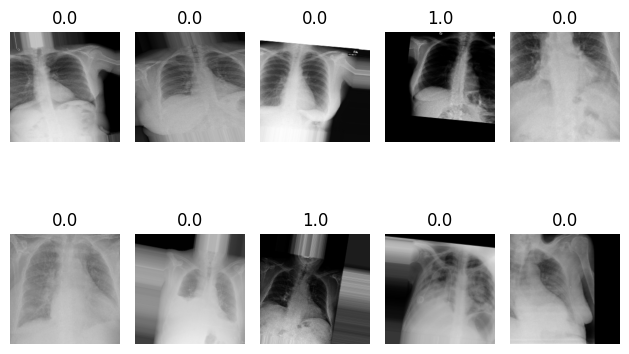

In [9]:
# Genera un batch di immagini e le relative etichette dal generatore di dati di addestramento
images, labels = next(train_gen)

# Crea una visualizzazione di 10 immagini e le loro etichette
for i in range(10):
    plt.subplot(2, 5, i + 1)
    random_offset = random.randint(1, 10)
    if i+random_offset > len(images): random_offset=0
    plt.imshow(images[i])
    plt.title(labels[i])
    plt.axis('off')



# Mostra la visualizzazione
print(train_gen.class_indices)
plt.tight_layout()
plt.show()

#METODI AUSILIARI PER IL TRAINING (Da spostare in un altro file)

In [29]:
import os
import pandas as pd
from tensorflow.keras.callbacks import Callback

class CSVLoggerCallback(Callback):
    def __init__(self, path):
        super(CSVLoggerCallback, self).__init__()
        self.path = path
        self.history_file = os.path.join(self.path, 'training_history.csv')

        # Crea la directory se non esiste
        if not os.path.exists(self.path):
            os.makedirs(self.path)

        # Controllo se il file CSV esiste già
        self.file_exists = os.path.exists(self.history_file)

    def on_epoch_end(self, epoch, logs=None):
        # Estrazione dei dati di interesse alla fine dell'epoca
        logs = logs or {}
        epoch_data = {
            'epoch': [epoch + 1],
            'training_accuracy': [logs.get('accuracy')],
            'training_loss': [logs.get('loss')],
            'validation_accuracy': [logs.get('val_accuracy')],
            'validation_loss': [logs.get('val_loss')]
        }

        # Creiamo un DataFrame per la singola epoca
        epoch_df = pd.DataFrame(epoch_data)

        # Se il file esiste già, appendo i nuovi dati senza intestazione
        if self.file_exists:
            epoch_df.to_csv(self.history_file, mode='a', header=False, index=False)
        else:
            # Se il file non esiste, lo creo con l'intestazione
            epoch_df.to_csv(self.history_file, index=False)
            self.file_exists = True  # Ora il file esiste

        print(f"Salvati i dati dell'epoca {epoch + 1} in {self.history_file}")

# Utilizzo della callback con il model.fit
#csv_logger = CSVLoggerCallback('/content/drive/MyDrive/AAoMC/trained_model')

#history = model.fit(train_gen,
#                    validation_data=val_gen,
#                    epochs=50,
#                    callbacks=[csv_logger, checkpoint, stop_early])


In [ ]:
import os
import pandas as pd

def save_training_history(history, path):
    # Crea la directory se non esiste
    if not os.path.exists(path):
        os.makedirs(path)

    # Estrae i dati di accuracy e loss dal dizionario history
    history_data = {
        'epoch': list(range(1, len(history.history['accuracy']) + 1)),
        'training_accuracy': history.history['accuracy'],
        'training_loss': history.history['loss'],
        'validation_accuracy': history.history['val_accuracy'],
        'validation_loss': history.history['val_loss']
    }

    # Crea un DataFrame da salvare in formato CSV
    df = pd.DataFrame(history_data)

    # Salva il DataFrame in un file CSV
    history_file = os.path.join(path, 'training_history.csv')
    df.to_csv(history_file, index=False)

    print(f"Dati di training salvati in: {history_file}")

# Esempio di utilizzo dopo l'addestramento
# history = model.fit(train_gen, validation_data=val_gen, epochs=50)
# save_training_history(history, '/content/drive/MyDrive/AAoMC/trained_model')


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import re

def get_latest_epoch_number(folder_path):
    # Espressione regolare per trovare i file con il pattern "model_epoch_0N.keras"
    pattern = r'model_epoch_(\d+)\.keras'

    # Lista per tenere traccia dei numeri di epoca
    epoch_numbers = []

    # Cerca i file nella cartella
    for filename in os.listdir(folder_path):
        # Cerca una corrispondenza con il pattern
        match = re.match(pattern, filename)
        if match:
            epoch_num = int(match.group(1))  # Estrae il numero dell'epoca
            epoch_numbers.append(epoch_num)

    # Controlla se ci sono file corrispondenti
    if not epoch_numbers:
        return None  # Nessun file trovato con il pattern

    # Restituisce il numero di epoca maggiore
    return max(epoch_numbers)


In [22]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def load_model(model, model_path):
    # Carica il modello dai pesi salvati
    best_model = get_latest_epoch_number(model_path)
    model.load_weights(os.path.join(model_path, "model_epoch_" + str(best_model) + ".keras"))

    # Stampare il sommario del modello
    print(model.summary())

    # Percorsi dei grafici salvati
    accuracy_path = os.path.join(os.path.dirname(model_path), 'accuracy_plot.png')
    loss_path = os.path.join(os.path.dirname(model_path), 'loss_plot.png')

    # Mostra il plot dei valori di accuratezza
    if os.path.exists(accuracy_path):
        accuracy_plot = mpimg.imread(accuracy_path)
        plt.imshow(accuracy_plot)
        plt.axis('off')
        plt.show()
    else:
        print(f"File di accuracy non trovato in {accuracy_path}")

    # Mostra il plot dei valori di perdita
    if os.path.exists(loss_path):
        loss_plot = mpimg.imread(loss_path)
        plt.imshow(loss_plot)
        plt.axis('off')
        plt.show()
    else:
        print(f"File di loss non trovato in {loss_path}")

    # Percorso del file CSV con la storia del training
    history_csv_path = os.path.join(model_path, 'training_history.csv')

    # Controlla se il file CSV esiste
    if os.path.exists(history_csv_path):
        # Carica il file CSV
        training_history = pd.read_csv(history_csv_path)
        print("\nContenuto di training_history.csv:\n")
        print(training_history)
    else:
        print(f"File CSV 'training_history.csv' non trovato in {history_csv_path}")



In [12]:
import os
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

def train_model(model, path, train_gen, val_gen, epochs=50):
    if not os.path.exists(path):
        os.makedirs(path)

    # EarlyStopping per fermare l'addestramento se il modello non migliora
    stop_early = EarlyStopping(monitor="val_loss", patience=5, verbose=1)

    # ModelCheckpoint per salvare il miglior modello basato su val_accuracy
    checkpoint = ModelCheckpoint(
        filepath=os.path.join(path, "model_epoch_{epoch:02d}.keras"),
        monitor='val_accuracy',
        verbose=1,
        save_best_only=True,
        mode='max'
    )

    # CSVLoggerCallback per monitorare come cambia l'accuracy e la loss ad ogni epoch
    csv_logger = CSVLoggerCallback(path)


    # Eseguo il training con il model e i dataset di training e validation
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=epochs,
        callbacks=[csv_logger, checkpoint, stop_early]
    )

    # Salvataggio del grafico di accuratezza
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.savefig(os.path.join(path, 'accuracy_plot.png'))
    plt.show()

    # Salvataggio del grafico di perdita
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.savefig(os.path.join(path, 'loss_plot.png'))
    plt.show()


In [26]:
# Carica il modello dal checkpoint (l'ultimo salvato)
def continue_model(model, model_path, train_gen, val_gen, epochs=50):
  load_model(model, model_path)

  # EarlyStopping per fermare l'addestramento se il modello non migliora
  stop_early = EarlyStopping(monitor="val_loss", patience=5, verbose=1)

  # ModelCheckpoint per salvare il miglior modello basato su val_accuracy
  checkpoint = ModelCheckpoint(
      filepath=os.path.join(model_path, "model_epoch_{epoch:02d}.keras"),
      monitor='val_accuracy',
      verbose=1,
      save_best_only=True,
      mode='max'
  )

  # CSVLoggerCallback per monitorare come cambia l'accuracy e la loss ad ogni epoch
  csv_logger = CSVLoggerCallback(model_path)

  # Continua il training da dove è stato interrotto
  history = model.fit(
      train_gen,
      validation_data=val_gen,
      initial_epoch=get_latest_epoch_number(model_path),  # Imposta l'epoca iniziale a 26 (ultimo checkpoint salvato)
      epochs=50,         # Continua fino all'epoca 50 o più, se desiderato
      callbacks=[csv_logger, checkpoint, stop_early]  # Mantieni le callback originali
  )


In [13]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Costruzione del modello CNN aggiornato per immagini 224x224
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(2, 2),
    Dropout(0.25),  # Dropout leggero dopo il primo blocco Conv-Pool

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Dropout(0.25),  # Dropout leggero dopo il secondo blocco Conv-Pool

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Dropout(0.25),  # Dropout leggero dopo il terzo blocco Conv-Pool

    Conv2D(256, (3, 3), activation='relu'),  # Aggiungi un livello con più filtri
    MaxPooling2D(2, 2),
    Dropout(0.25),  # Dropout leggero dopo il quarto blocco Conv-Pool

    Flatten(),

    Dense(1024, activation='relu'),  # Aumento del numero di neuroni Fully Connected
    Dropout(0.5),  # Dropout più alto prima del Dense layer finale

    Dense(1, activation='sigmoid')  # Output layer per classificazione binaria
])

# Compilazione del modello
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])




model_path = "/content/drive/MyDrive/AAoMC/model/01"
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 24, 24, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 36864)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │      37,749,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │           1,025 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 38,139,201 (145.49 MB)

 Trainable params: 38,139,201 (145.49 MB)

 Non-trainable params: 0 (0.00 B)

#TEST PER ALLENARE I MODELLI

In [27]:
#model = ...  # Definizione del tuo modello CNN
continue_model(model, model_path, train_gen, val_gen)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 24, 24, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 36864)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │      37,749,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │           1,025 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 114,417,605 (436.47 MB)

 Trainable params: 38,139,201 (145.49 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 76,278,404 (290.98 MB)

None
File di accuracy non trovato in /content/drive/MyDrive/AAoMC/model/accuracy_plot.png
File di loss non trovato in /content/drive/MyDrive/AAoMC/model/loss_plot.png
Epoch 27/50
371/371 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7999 - loss: 0.4823

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 27: val_accuracy improved from -inf to 0.81272, saving model to /content/drive/MyDrive/AAoMC/model/01/model_epoch_27.keras
371/371 ━━━━━━━━━━━━━━━━━━━━ 1260s 3s/step - accuracy: 0.7999 - loss: 0.4823 - val_accuracy: 0.8127 - val_loss: 0.4774
Epoch 28/50
152/371 ━━━━━━━━━━━━━━━━━━━━ 12:29 3s/step - accuracy: 0.8084 - loss: 0.4615

KeyboardInterrupt: 

In [23]:
load_model(model, model_path)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 24, 24, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 36864)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │      37,749,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │           1,025 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 114,417,605 (436.47 MB)

 Trainable params: 38,139,201 (145.49 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 76,278,404 (290.98 MB)

None
File di accuracy non trovato in /content/drive/MyDrive/AAoMC/model/accuracy_plot.png
File di loss non trovato in /content/drive/MyDrive/AAoMC/model/loss_plot.png


In [33]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Costruzione del modello CNN aggiornato per immagini 224x224
model_test = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(2, 2),
    Dropout(0.25),  # Dropout leggero dopo il primo blocco Conv-Pool

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Dropout(0.25),  # Dropout leggero dopo il secondo blocco Conv-Pool

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Dropout(0.25),  # Dropout leggero dopo il terzo blocco Conv-Pool

    Conv2D(256, (3, 3), activation='relu'),  # Aggiungi un livello con più filtri
    MaxPooling2D(2, 2),
    Dropout(0.25),  # Dropout leggero dopo il quarto blocco Conv-Pool

    Flatten(),

    Dense(1024, activation='relu'),  # Aumento del numero di neuroni Fully Connected
    Dropout(0.5),  # Dropout più alto prima del Dense layer finale

    Dense(1, activation='sigmoid')  # Output layer per classificazione binaria
])

# Compilazione del modello
model_test.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])




model_test_path = "/content/drive/MyDrive/AAoMC/model/02"
model_test.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 24, 24, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 36864)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1024)                │      37,749,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │           1,025 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 38,139,201 (145.49 MB)

 Trainable params: 38,139,201 (145.49 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:

train_model(model_test, model_test_path, train_gen, val_gen, epochs=10)

Epoch 1/10
345/371 ━━━━━━━━━━━━━━━━━━━━ 1:20 3s/step - accuracy: 0.6288 - loss: 0.7785